In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.exceptions import ConvergenceWarning
import warnings
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

# Load the model

In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'EleutherAI/pythia-6.9b'##'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Generate the mathematical expressions

In [3]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}_{MODEL_NAME}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}_{MODEL_NAME}.pkl')
    
df = get_df_sample(run = False)


# Helper function to get hidden states

In [4]:
ANS_SEQPOS = -1 # across all models, this is the token where the value is
def run_hs(mina = 0, maxa = 99, batch_size = 80, sample = False):
    if sample:
        df = get_df_sample(mina, maxa, run = False)
    else:
        df = get_correct_df(mina, maxa)
    a = torch.tensor(df['a'].values)
    b = torch.tensor(df['b'].values)
    a_b = a+b
    hss = []
    for step in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[step:min(step + batch_size, len(df))]
        tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
        layer_hss = []
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].output[0].save()
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].output[0].save()
                    elif MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].output[0].save()
                    layer_hss.append(hs)
        layer_hss = [layer_hs[:,ANS_SEQPOS].detach().cpu() for layer_hs in layer_hss] # gets hs on top of ans_token
        layer_hss = torch.stack(layer_hss, dim=1) # stack along new layer dimension
        hss.append(layer_hss)
    hss = torch.cat(hss, dim=0) # concat along batch dimension
    # Save nums and hss to file with descriptive name
    # Use _FULL in filename if using complete dataset
    suffix = '_FULL' if not sample else ''
    save_path = f'data/ab_helix_hss/ab_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs('data/ab_helix_hss', exist_ok=True)
    # Save tensors
    torch.save({
        'a': a,
        'b':b,
        'a+b':a_b,
        'hidden_states': hss
    }, save_path)
    return a,b,a_b, hss

def get_nums_hss(mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'data/ab_helix_hss/ab_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

run_hs(sample = True)
run_hs(sample = False)
#get_nums_hss(num_sample = False)

  0%|          | 0/7 [00:00<?, ?it/s]You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 123/123 [00:23<00:00,  5.13it/s]


(tensor([ 0,  0,  0,  ..., 99, 99, 99]),
 tensor([ 0,  1,  2,  ..., 97, 98, 99]),
 tensor([  0,   1,   2,  ..., 196, 197, 198]),
 tensor([[[ 1.2817e-02, -3.7842e-03, -3.3417e-03,  ..., -9.5215e-03,
           -9.2773e-03, -1.6357e-02],
          [ 2.5635e-02, -3.8574e-02, -2.5513e-02,  ..., -3.0029e-02,
           -2.0630e-02, -2.0020e-02],
          [ 3.2959e-03, -7.0801e-02, -3.9551e-02,  ...,  3.0273e-02,
           -3.2227e-02, -6.2500e-02],
          ...,
          [ 4.1406e-01,  2.7344e-01,  6.1719e-01,  ...,  2.5195e-01,
           -8.6719e-01,  3.4375e-01],
          [ 2.5586e-01,  8.3984e-02,  8.9062e-01,  ..., -5.2734e-02,
           -1.1953e+00,  0.0000e+00],
          [-9.6484e-01, -4.4141e-01,  2.2969e+00,  ...,  2.7734e-01,
            3.2031e-01,  5.5664e-02]],
 
         [[ 1.4404e-02, -4.3335e-03, -4.9744e-03,  ..., -7.1411e-03,
           -9.2773e-03, -1.3428e-02],
          [ 1.9165e-02, -3.9551e-02, -2.4536e-02,  ..., -2.2095e-02,
           -1.9531e-02, -1.4954e-02

# PCA Functions

In [5]:
def run_pca(mina = 0, maxa = 99, NUM_PCA = 500):
    _,_,_, hss = get_nums_hss(mina, maxa, sample = False) # we want the full thing for a pca
    pca_components = {}
    for layer in tqdm(range(hss.shape[1])):
        hs = hss[:,layer]
        # Convert to numpy for sklearn
        hs_numpy = hs.float().numpy()
        # Fit PCA without dimensionality reduction
        pca = PCA(n_components=NUM_PCA)# None
        pca.fit(hs_numpy)
        # Store components for this layer
        pca_components[layer] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'components': pca.components_,
            'singular_values': pca.singular_values_,
            'mean': pca.mean_
        }
    # Save PCA components to file with descriptive name
    save_path = f'data/ab_helix_pca/ab_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    # Create directory if it doesn't exist
    os.makedirs('data/ab_helix_pca', exist_ok=True)
    # Save dictionary
    torch.save(pca_components, save_path)
    return pca_components

def get_pca(layer, mina = 0, maxa = 99):
    save_path = f'data/ab_helix_pca/ab_pca_data_{mina}_{maxa}_{MODEL_NAME}.pt'
    pca_data = torch.load(save_path, weights_only = False)[layer]
    return pca_data

#get_pca(5)
run_pca()

100%|██████████| 32/32 [04:55<00:00,  9.22s/it]


{0: {'explained_variance_ratio': array([5.29129386e-01, 1.06653608e-01, 8.86527598e-02, 2.45980080e-02,
         2.06381530e-02, 1.88366491e-02, 1.72345210e-02, 1.40476907e-02,
         1.31922597e-02, 9.37175192e-03, 8.28966871e-03, 7.37215765e-03,
         6.12626923e-03, 5.26532112e-03, 4.88783605e-03, 4.75747464e-03,
         4.33862256e-03, 4.15833294e-03, 3.96376010e-03, 3.80809489e-03,
         3.75281298e-03, 3.47141852e-03, 3.36594856e-03, 3.30987922e-03,
         3.09108337e-03, 2.97415955e-03, 2.89859297e-03, 2.63383589e-03,
         2.56947288e-03, 2.47493386e-03, 2.38634972e-03, 2.35724868e-03,
         2.23441329e-03, 2.19054963e-03, 2.11148500e-03, 1.94715930e-03,
         1.91368605e-03, 1.87416037e-03, 1.79497676e-03, 1.70235522e-03,
         1.63047831e-03, 1.59984734e-03, 1.54409767e-03, 1.48118904e-03,
         1.47131423e-03, 1.43209612e-03, 1.41748344e-03, 1.33256859e-03,
         1.31930097e-03, 1.24232657e-03, 1.21104368e-03, 1.16135192e-03,
         1.13375101e

In [6]:
def get_pca_coords(layer, mina = 0, maxa = 99, npca = False, reconstruction = False):
    assert isinstance(npca, bool) or isinstance(npca, int), "npca must be either False or an integer"
    a,b,a_b, hss = get_nums_hss(mina, maxa, sample=True) # just take subset
    hss = hss[:,layer]
    pca_data = get_pca(layer, mina, maxa)
    pca_comps, pca_mean = pca_data['components'], pca_data['mean']
    assert hss.shape[0] == pca_comps.shape[0] # same batch
    # Project data into PCA space
    hs_numpy = hss.float().numpy()
    hs_centered = hs_numpy - pca_mean
    pca_coords = np.dot(hs_centered, pca_comps.T)
    if npca is False:
        npca = hss.shape[0] # make it full batch
    pca_coords = pca_coords[:, :npca]
    if reconstruction:
        reconstruction = torch.tensor(np.dot(pca_coords, pca_comps[:npca]) + pca_mean)
        #mse = torch.mean((reconstruction - hss) ** 2)
        #print(f"MSE between reconstruction and original hidden states: {mse:.6f}")
        return a,b,a_b, reconstruction
    else:
        return a,b,a_b, pca_coords

#get_pca_coords(18, reconstruction=True)

# Helix Fitting

In [7]:
def create_features(a,b,a_b, bases = [2,5,10,100]):
    nums = np.array([a,b,a_b])
    feature_list = []
    for i, num in enumerate(nums):
        for base in bases:
            t_scaled = 2 * np.pi * num / base
            feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        feature_list.append(num / max(num))  # Add linear term for helix
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features

def get_feature_names(bases = [2,5,10,100], helix_type = 'helix_a_b_ab'):
    assert helix_type in ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], f"helix_type must be one of ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], got {helix_type}"
    if helix_type == 'helix_ab':
        variables = ['a+b']
    elif helix_type == 'helix_a_b':
        variables = ['a', 'b']
    else:
        variables = ['a', 'b', 'a+b']
    feature_names = []
    for i in range(len(variables)):
        for base in bases:
            feature_names.extend([f'cos({variables[i]}|T = {base})', f'sin({variables[i]}|T = {base})'])
        feature_names.append(variables[i])
    feature_names.append('1')
    return feature_names # All features


In [8]:


def helix_fit(layer, helix_type, bases = [2,5,10,100], save=True):
    a,b,a_b, hss_projected_n = get_pca_coords(layer, mina = 0, maxa = 99, npca = False, reconstruction = False)
    nums = np.array([a,b,a_b])
    hss_original = get_nums_hss(mina= 0, maxa = 99)[-1][:,layer]
    pca_data = get_pca(layer, mina = 0, maxa = 99)
    pca_comp, pca_mean = pca_data['components'], pca_data['mean']
    helix_features = create_features(a,b,a_b, bases)
    feature_names = get_feature_names(bases, helix_type)
    batch = helix_features.shape[1]//3
    if helix_type == 'helix_a_b':
        helix_features = helix_features[:, :2*batch]
        helix_features = np.concatenate([helix_features, helix_features[:, -1:]], axis=1)
        feature_names = feature_names[:2*batch]
        feature_names = feature_names + [feature_names[-1]]
    elif helix_type == 'helix_ab':
        helix_features = helix_features[:, -batch-1:]
        feature_names = feature_names[-batch-1:]
    elif helix_type == 'helix_a_b_ab':
        helix_features = helix_features
        feature_names = feature_names
    # Split data for train/test if requested
    # Fit a separate linear model for each reduced dimension
    weights_by_dim = []
    predictions = np.zeros_like(hss_projected_n)
    models = []


    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(hss_projected_n.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(helix_features, hss_projected_n[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space = np.dot(predictions, pca_comp) + pca_mean
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - hss_original.float().numpy()) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    A_map = A @ pca_comp # 28, 4096
    #map mse
    #resid = helix_features @ A_map + pca_mean
    #print(np.mean((resid - hss_original.float().numpy()) ** 2))
    if save:
        save_dir = 'data_addition/ab_helix_fit/trained_fit'
        os.makedirs(save_dir, exist_ok=True)
        save_path = f"{save_dir}/helix_{helix_type}_fit_layer{layer}_{MODEL_NAME}.pkl"
        #print(save_path)
        with open(save_path, 'wb') as f:
            save_dict = {
                'a': a,
                'b':b,
                'a+b':a_b,
                'predictions_full': predictions_full_space,
                'A_map': A_map,
                'pca_mean': pca_mean, # resid = helix_features @ A_map + pca_mean.
                'feature_names': feature_names
            }
            pickle.dump(save_dict, f)
    return nums, predictions_full_space, mse

#x = helix_fit(layer = 18, helix_type = 'helix_a_b_ab')
#get_features([[1,2,3,4,5],[2,3,4,5,6], [3,5,7,9,11]], 'poly', [2,5,10,100]).shape
#x[-1]

In [9]:
def run_all_fits():
    # Create array to store MSE values
    helix_types = ['helix_a_b', 'helix_ab', 'helix_a_b_ab']
    mse_data = np.zeros((len(helix_types), NLAYERS))
    # Run fits and collect MSE values
    for layer in tqdm(range(NLAYERS)):
        for i, helix_type in enumerate(helix_types):
            _, _, mse = helix_fit(layer = layer, helix_type = helix_type)
            mse_data[i, layer] = mse
    
    # Plot MSE vs layers for each fit type
    plt.figure(figsize=(10, 6))
    for i, helix_type in enumerate(helix_types):
        plt.semilogy(range(NLAYERS), mse_data[i], label=helix_type)
    plt.xlabel('Layer')
    plt.ylabel('MSE (log scale)')
    plt.title('MSE vs Layer by Fit Type')
    plt.legend()
    plt.grid(True)
    # Create directories if they don't exist
    os.makedirs('figs/ab_allfits', exist_ok=True)
    os.makedirs('data/ab_meta_fits', exist_ok=True)
    
    plt.savefig(f'figs/ab_allfits/compositional_mse_by_layer_and_fit_{MODEL_NAME}.png')
    #plt.show()
    plt.close()
    
    # Save data array
    data_dict = {
        'fit_types': helix_types,
        'layers': list(range(NLAYERS)),
        'mse_data': mse_data
    }
    with open(f'data/ab_meta_fits/ab_compositional_mse_fits_{MODEL_NAME}.pkl', 'wb') as f:
        pickle.dump(data_dict, f)

run_all_fits()

100%|██████████| 32/32 [04:21<00:00,  8.16s/it]


# Run Intervention

In [10]:
def pca_projection(nums, npca, mina, maxa, layer):
    a,b,a_b, reconstruction = get_pca_coords(layer, mina, maxa, npca = npca, reconstruction = True)
    # Find matching indices using a for loop
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return reconstruction[matching_indices]

#pca_projection([[32,77,32],[56,0,56],[88,77,88]], mina = 0, maxa = 99, layer = 0, npca=2)

In [11]:
def find_fit(helix_type, layer):
    save_path = f'data_addition/ab_helix_fit/trained_fit/helix_{helix_type}_fit_layer{layer}_{MODEL_NAME}.pkl'
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data


def get_fit(nums, helix_type, layer):
    data = find_fit(helix_type, layer)
    a,b,a_b, allhss = data['a'],data['b'],data['a+b'], data['predictions_full']
    allnums = np.array([a,b,a_b])
    
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return torch.tensor(allhss[matching_indices])

#get_fit([[32,77,32],[56,0,56],[88,77,88]], helix_type = 'helix_a_b_ab', layer = 0)

# Interventions

In [12]:
def gen_intervention(mina, maxa, samplesize = 1000, run = False):
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        intervention_df = intervention_df[intervention_df['answer_original'] != intervention_df['answer_intervened']]
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    intervention_df = pd.read_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    return intervention_df

gen_intervention(0,99, run = True)

,a_original,b_original,q_string_original,q_tok_original,answer_original,answer_tok_original,correct_original,a_intervened,b_intervened,q_string_intervened,q_tok_intervened,answer_intervened,answer_tok_intervened,correct_intervened
0,47,93,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",140,[6860],tensor(1.),62,17,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",79,[4643],tensor(1.)
1,81,98,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",179,[11128],tensor(1.),91,25,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",116,[8027],tensor(1.)
2,32,32,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",64,[1227],tensor(1.),30,96,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",126,[9390],tensor(1.)
3,53,0,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",53,[4331],tensor(1.),87,89,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",176,[10967],tensor(1.)
4,2,65,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",67,[3080],tensor(1.),63,22,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",85,[5313],tensor(1.)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,35,75,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",110,[5120],tensor(1.),95,9,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",104,[6849],tensor(1.)
996,50,16,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",66,[2287],tensor(1.),49,24,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",73,[5958],tensor(1.)
997,68,20,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",88,[2421],tensor(1.),32,32,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",64,[1227],tensor(1.)
998,63,90,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",153,[9800],tensor(1.),36,94,The following is a correct addition problem. \...,"[128000, 791, 2768, 374, 264, 4495, 5369, 3575...",130,[5894],tensor(1.)


In [13]:
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def run_intervention(patch_dict, mina = 0, maxa = 99, layer=15, batch_size=100, verbose = False):
    df = gen_intervention(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    metrics = {'accuracy':[], 'logit_diff':[]}
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            corrupt_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_intervened'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            patch_type = patch_dict['patch_type']
            if 'pca' in patch_type:
                npca = int(patch_dict['patch_type'].split('_')[1])
                exchange = pca_projection(nums, npca, mina, maxa, layer)
            elif 'exchange' in patch_type:
                with model.trace(validate=False, remote=remote) as tracer:
                    with tracer.invoke(corrupt_tokens, scan=False):
                        if MODEL_NAME == 'gpt-j-6B':
                            exchange = model.transformer.h[layer].output[0][:,ANS_SEQPOS].save()
                        elif MODEL_NAME == 'pythia-6.9b':
                            exchange = model.gpt_neox.layers[layer].output[0][:,ANS_SEQPOS].save()
                        elif MODEL_NAME == 'Llama-3.1-8B':
                            exchange = model.model.layers[layer].output[0][:,ANS_SEQPOS].save()
            elif 'helix' in patch_type:
                exchange = get_fit(nums, patch_type, layer)
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    pass
                original_output = model.output.save()
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    if MODEL_NAME == 'gpt-j-6B':
                        m = model.transformer.h[layer]
                    elif MODEL_NAME == 'pythia-6.9b':
                        m = model.gpt_neox.layers[layer]
                    elif MODEL_NAME == 'Llama-3.1-8B':
                        m = model.model.layers[layer]
                    exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)
                    m.output[0][:,ANS_SEQPOS, :] = exchange
                intervened_output = model.output.save()
            original_logits, patched_logits = original_output.logits[:,-1], intervened_output.logits[:,-1]

            model_answers = patched_logits.argmax(dim=-1)
            correct = (model_answers == patched_answer_tokens).int()
            metrics['accuracy'].extend(correct.cpu().tolist())
            log_diff = calc_log_diff(original_logits, patched_logits, patched_answer_tokens)
            metrics['logit_diff'].extend(log_diff.cpu().tolist())
            wrong_idxs = (correct == 0).nonzero().squeeze().detach().cpu().tolist()
            wrong_idxs = wrong_idxs if isinstance(wrong_idxs, list) else [wrong_idxs]
            if wrong_idxs and verbose:
                print(f"Wrong predictions: {model.tokenizer.batch_decode(model_answers[wrong_idxs])}")
                print(f"Target answers: {target_answers[wrong_idxs]}")
                print(f"Original answers: {original_answers[wrong_idxs]}")
    
    return {k: np.mean(v).item() for k,v in metrics.items()}
patch_dict = {'patch_type': 'pca_9'}
patch_dict = {'patch_type':'helix_a_b_ab'}
patch_dict = {'patch_type': 'exchange'}
run_intervention(patch_dict, mina = 0, maxa = 99, layer=25, verbose =True, batch_size=100)



{'accuracy': 1.0, 'logit_diff': 5.9065625}

In [14]:
def run_all_fits(): 
    fit_types = ['helix_a_b', 'helix_ab', 'helix_a_b_ab', 'pca_9','pca_27', 'exchange']
    filename = f"data/ab_meta_fits/ab_fit_metrics_{MODEL_NAME}.pkl"
    # Initialize dictionary to store all metrics for each fit type
    metrics_data = {
        'accuracy': np.zeros((len(fit_types), NLAYERS)),
        'logit_diff': np.zeros((len(fit_types), NLAYERS)),
    }
    # Run interventions and store metrics
    bar = tqdm([(l,i,ft) for l in range(NLAYERS) for i,ft in enumerate(fit_types)])
    for (layer, i, fit_type) in bar:
        patching_dict = {'patch_type': fit_type}
        metrics = run_intervention(patching_dict, layer=layer, batch_size = 100)
        # Store each metric
        for metric_name in metrics_data.keys():
            metrics_data[metric_name][i, layer] = metrics[metric_name]
        bar.set_postfix({'layer':layer, 'fit_type':fit_type, **metrics})
    
        # Save metrics and metadata
    with open(filename, 'wb') as f:
        pickle.dump({
            'metrics': metrics_data,
            'fit_types': fit_types,
            'n_layers': NLAYERS
        }, f)
run_all_fits()
# 8 ITERATIONS COMPLETED ALREADY

100%|██████████| 192/192 [03:11<00:00,  1.00it/s, layer=31, fit_type=exchange, accuracy=1, logit_diff=5.93]       


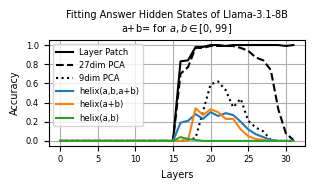

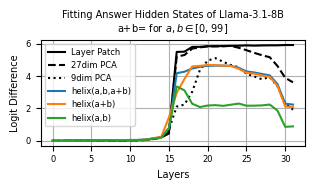

In [15]:
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}
def plot_all_fits():
    filename = f"data/ab_meta_fits/ab_fit_metrics_{MODEL_NAME}.pkl"
    # Load saved results
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        metrics_data = data['metrics']
        fit_types = data['fit_types']
    fit_types = fit_types[::-1]
    for metric in metrics_data.keys():
        data = metrics_data[metric][::-1]
        plt.figure(figsize = (3.25,2))
        linestyles = {'pca_9':':', 'pca_27':'--', 'exchange': '-'}
        for i,fit_type in enumerate(fit_types):
            if 'pca' in fit_type or 'exchange' in fit_type:
                plt.plot(list(range(NLAYERS)), 
                    data[i],
                    label=f'{mapping[fit_type]}',
                    linestyle = linestyles[fit_type],
                    color = 'k')
            else:
                plt.plot(list(range(NLAYERS)), 
                        data[i],
                        label=f'{mapping[fit_type]}')

        plt.title(f'Fitting Answer Hidden States of {MODEL_NAME}\na+b= for '+r'$a,b \in$'+f'[{0}, {99}]')
        plt.xlabel('Layers')
        metrics = {'accuracy': "Accuracy", 'logit_diff': 'Logit Difference'}
        plt.ylabel(metrics[metric])
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'figs/ab_allfits/ab_fits_{metric}_{MODEL_NAME}.png', dpi = 300, bbox_inches =  'tight')
        plt.show()

plot_all_fits()
        

# Plot fit map

/tmp/ipykernel_2025837/3757055932.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = reconstruction-hss_original.float().numpy()


tensor(0.0032)


ValueError: Format '1-8b' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

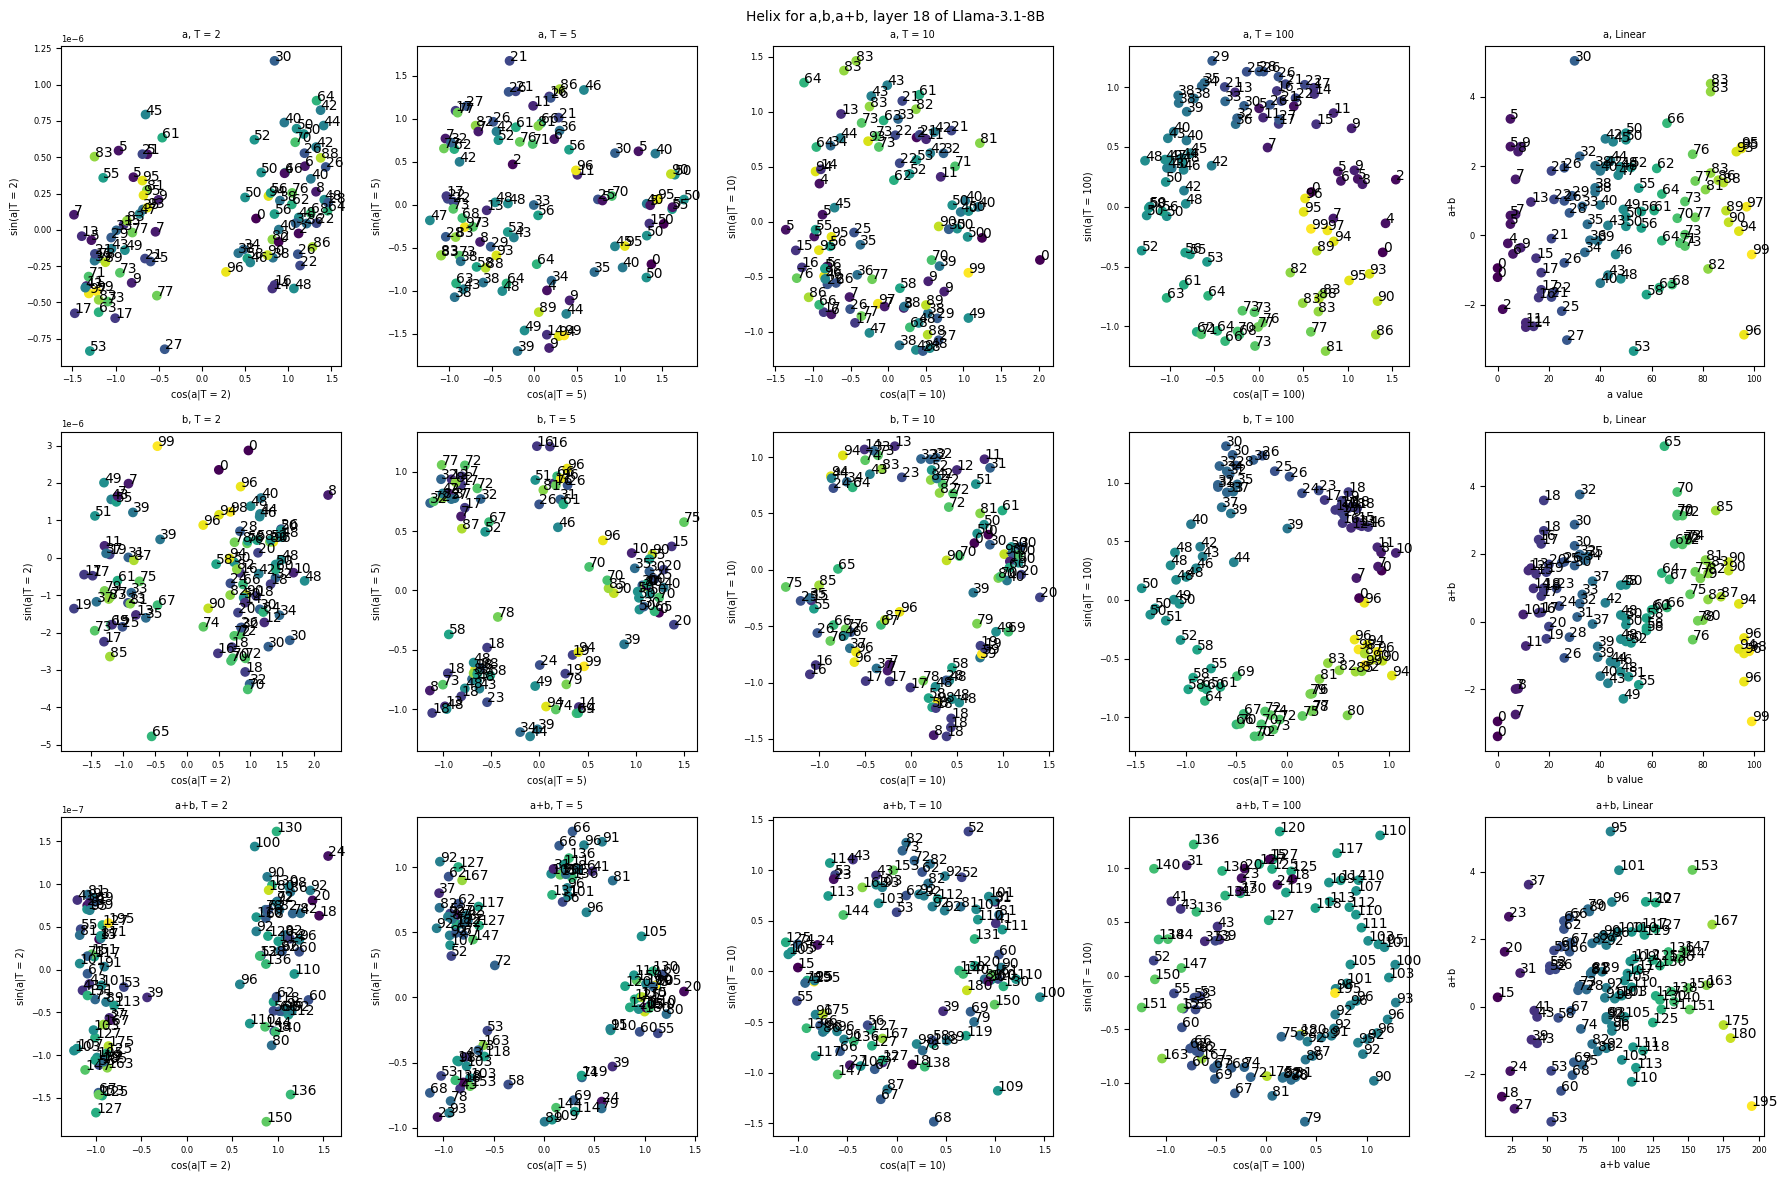

In [16]:

def plot_fit_map(helix_type, layer):
    data = find_fit(helix_type, layer)
    A_map, pca_mean = torch.tensor(data['A_map']).float(), torch.tensor(data['pca_mean'])
    feature_names = data['feature_names']
    a,b,a_b, hss_original = get_nums_hss(mina = 0, maxa = 99)
    hss_original = hss_original[:,layer]
    A_map_pseudo = torch.linalg.pinv(A_map) 
    helix_features = (hss_original - pca_mean) @ A_map_pseudo
    reconstruction = helix_features @ A_map + pca_mean
    diff = reconstruction-hss_original.float().numpy()
    print((diff**2).mean())
    # get rid of bias
    num_plot = 100
    helix_features, feature_names = helix_features[:num_plot,:-1], feature_names[:-1]
    a, b, a_b = a[:num_plot], b[:num_plot], a_b[:num_plot]
    
    # Split into a, b, and a+b sections
    a_features = helix_features[:,:9]
    b_features = helix_features[:,9:18] 
    ab_features = helix_features[:,18:]
    
    # Create figure with subplots - 3 rows, 5 columns
    fig, axs = plt.subplots(3, 5, figsize=(18, 12))
    
    # Get colormaps for a, b, and a+b values
    norm_a = plt.Normalize(a.min(), a.max())
    norm_b = plt.Normalize(b.min(), b.max())
    norm_ab = plt.Normalize(a_b.min(), a_b.max())
    cmap = plt.cm.viridis
    
    # Plot for each row (a, b, a+b)
    for row, (features, values, norm, title) in enumerate([(a_features, a, norm_a, 'a'), 
                                                         (b_features, b, norm_b, 'b'),
                                                         (ab_features, a_b, norm_ab, 'a+b')]):
        
        # Plot pairs of dimensions
        n_pairs = features.shape[1] // 2
        for i in range(n_pairs):
            # Get feature indices for this pair
            idx1, idx2 = 2*i, 2*i+1
            # Create scatter plot
            scatter = axs[row,i].scatter(features[:,idx1], 
                                       features[:,idx2],
                                       c=values[:100],
                                       cmap=cmap, 
                                       norm=norm)
            
            # Set labels
            axs[row,i].set_xlabel(feature_names[idx1])
            axs[row,i].set_ylabel(feature_names[idx2])
            
            # Add value annotations
            for j, txt in enumerate(values[:100]):
                axs[row,i].annotate(f'{int(txt)}', 
                                  (features[j,idx1], features[j,idx2]))
                
            # Add T annotation
            axs[row,i].set_title(f'{title}, T = {[2,5,10,100][i]}')
        
        # Plot values vs last feature
        scatter = axs[row,-1].scatter(values[:100], features[:,-1], 
                                    c=values[:100], cmap=cmap, norm=norm)
        axs[row,-1].set_xlabel(f'{title} value')
        axs[row,-1].set_ylabel(feature_names[-1])
        axs[row,-1].set_title(f'{title}, Linear')
        
        # Add value annotations to linear plot
        for j, txt in enumerate(values[:100]):
            axs[row,-1].annotate(f'{int(txt)}', 
                              (values[j], features[j,-1]))
    plt.suptitle(f'Helix for a,b,a+b, layer {layer} of {MODEL_NAME}')
    plt.tight_layout()
    plt.savefig(f"figs_addition/ab_helix/{helix_type}_vis_layer{layer}_{MODEL_NAME}")
    plt.show()


plot_fit_map('helix_a_b_ab',18)
